In [1]:
import torch, sys
sys.path.append("../")
from ad_utils import *
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train, X_test, y_train, y_test = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)

NVIDIA A30
(872, 4500, 14) (872,)


# Conditional GAN

In [2]:
# Enhanced Conv1D Generator for Time Series
class Conv1DConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=2, num_features=14, seq_len=4500):
        super(Conv1DConditionalGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.num_features = num_features
        self.seq_len = seq_len
        
        # Label embedding
        self.label_emb = nn.Embedding(num_classes, 50)
        
        # Initial size after first linear layer
        self.init_size = seq_len // 64  # Will be upsampled
        input_dim = latent_dim + 50  # latent + label embedding
        
        # Initial projection
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256 * self.init_size),
            nn.BatchNorm1d(256 * self.init_size),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Conv1D upsampling blocks
        self.conv_blocks = nn.Sequential(
            # Block 1: 256 -> 128 channels
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 2: 128 -> 64 channels  
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 3: 64 -> 32 channels
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 4: 32 -> 16 channels
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 5: 16 -> 8 channels
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final block: 8 -> num_features channels
            nn.ConvTranspose1d(8, num_features, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in [-1, 1] range
        )
        
    def forward(self, z, labels):
        # Embed labels
        label_emb = self.label_emb(labels)  # (batch_size, 50)
        
        # Concatenate noise and label embedding
        gen_input = torch.cat((z, label_emb), dim=1)  # (batch_size, latent_dim + 50)
        
        # Project to initial size
        out = self.fc(gen_input)  # (batch_size, 256 * init_size)
        out = out.view(out.shape[0], 256, self.init_size)  # (batch_size, 256, init_size)
        
        # Apply conv blocks
        out = self.conv_blocks(out)  # (batch_size, num_features, length)
        
        # Ensure correct sequence length
        if out.shape[2] != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        # Transpose to (batch_size, seq_len, num_features)
        return out.transpose(1, 2)

# Enhanced Conv1D Discriminator for Time Series
class Conv1DConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=2, num_features=14, seq_len=4500):
        super(Conv1DConditionalDiscriminator, self).__init__()
        self.num_classes = num_classes
        self.num_features = num_features
        self.seq_len = seq_len
        
        # Label embedding and projection
        self.label_emb = nn.Embedding(num_classes, 50)
        self.label_proj = nn.Linear(50, seq_len)
        
        # Conv1D blocks for feature extraction
        self.conv_blocks = nn.Sequential(
            # Input: (num_features + 1) channels, seq_len length
            nn.Conv1d(num_features + 1, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate the size after convolutions
        self.conv_output_size = self._get_conv_output_size()
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * self.conv_output_size, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
    def _get_conv_output_size(self):
        size = self.seq_len
        for _ in range(6):  # 6 conv layers
            size = (size - 4 + 2) // 2 + 1
        return size
    
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        # Embed and project labels to match sequence length
        label_emb = self.label_emb(labels)  # (batch_size, 50)
        label_seq = self.label_proj(label_emb)  # (batch_size, seq_len)
        label_seq = label_seq.unsqueeze(1)  # (batch_size, 1, seq_len)
        
        # Transpose x to (batch_size, num_features, seq_len)
        x = x.transpose(1, 2)
        
        # Concatenate data and label along feature dimension
        x_labeled = torch.cat([x, label_seq], dim=1)  # (batch_size, num_features + 1, seq_len)
        
        # Apply conv blocks
        features = self.conv_blocks(x_labeled)  # (batch_size, 512, conv_output_size)
        
        # Flatten and classify
        features_flat = features.view(batch_size, -1)
        output = self.classifier(features_flat)
        
        return output

# Enhanced training function with improved stability
def train_conditional_gan_conv1d(normal_data, normal_labels, device, epochs=50, batch_size=64, lr_g=0.0002, lr_d=0.0001):
    """
    Train Conditional GAN with Conv1D layers for time series data - IMPROVED VERSION
    """
    print(f"Training data shape: {normal_data.shape}")
    print(f"Labels shape: {normal_labels.shape}")
    
    # Model parameters - FIXED num_classes
    latent_dim = 100
    num_classes = 2  # Binary classification: normal (0) and fault (1)
    num_features = normal_data.shape[-1]
    seq_len = normal_data.shape[1]
    
    print(f"Model parameters: latent_dim={latent_dim}, num_classes={num_classes}, num_features={num_features}, seq_len={seq_len}")
    
    # Initialize models
    generator = Conv1DConditionalGenerator(latent_dim, num_classes, num_features, seq_len).to(device)
    discriminator = Conv1DConditionalDiscriminator(num_classes, num_features, seq_len).to(device)
    
    # Weight initialization with spectral normalization for discriminator stability
    def weights_init(m):
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.BatchNorm1d)):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)
    
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    # Optimizers with better stability parameters
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999), weight_decay=1e-5)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999), weight_decay=1e-5)
    
    # Learning rate schedulers for adaptive training
    scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='min', factor=0.8, patience=15, verbose=True)
    scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(optimizer_D, mode='min', factor=0.8, patience=15, verbose=True)
    
    # Loss functions with label smoothing for stability
    criterion = nn.BCEWithLogitsLoss()
    
    # Create dataloader
    dataset = TensorDataset(
        torch.tensor(normal_data, dtype=torch.float32),
        torch.tensor(normal_labels, dtype=torch.long)
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    print("Starting Conv1D Conditional GAN training with improved stability...")
    print(f"Learning rates - Generator: {lr_g}, Discriminator: {lr_d}")
    
    # Training history
    d_losses = []
    g_losses = []
    
    # Training parameters for stability
    d_train_freq = 1  # Train discriminator every iteration
    g_train_freq = 2  # Train generator every 2 iterations
    
    for epoch in range(epochs):
        epoch_d_losses = []
        epoch_g_losses = []
        
        for i, (real_data, real_labels) in enumerate(dataloader):
            real_data = real_data.to(device)
            real_labels = real_labels.to(device)
            current_batch_size = real_data.size(0)
            
            # Label smoothing for stability
            valid = torch.ones(current_batch_size, 1, device=device) * 0.9  # Real label = 0.9
            fake = torch.zeros(current_batch_size, 1, device=device) + 0.1   # Fake label = 0.1
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            if i % d_train_freq == 0:
                optimizer_D.zero_grad()
                
                # Real data loss
                real_pred = discriminator(real_data, real_labels)
                d_real_loss = criterion(real_pred, valid)
                
                # Fake data loss - use both classes
                z = torch.randn(current_batch_size, latent_dim, device=device)
                gen_labels = torch.randint(0, num_classes, (current_batch_size,), device=device)
                fake_data = generator(z, gen_labels)
                fake_pred = discriminator(fake_data.detach(), gen_labels)
                d_fake_loss = criterion(fake_pred, fake)
                
                # Total discriminator loss
                d_loss = (d_real_loss + d_fake_loss) / 2
                d_loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 0.5)
                
                optimizer_D.step()
                epoch_d_losses.append(d_loss.item())
            
            # ---------------------
            #  Train Generator
            # ---------------------
            if i % g_train_freq == 0:
                optimizer_G.zero_grad()
                
                # Generate fake data
                z = torch.randn(current_batch_size, latent_dim, device=device)
                gen_labels = torch.randint(0, num_classes, (current_batch_size,), device=device)
                fake_data = generator(z, gen_labels)
                
                # Generator loss (want discriminator to classify fake as real)
                fake_pred = discriminator(fake_data, gen_labels)
                g_loss = criterion(fake_pred, valid)  # Use smoothed real labels
                
                g_loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(generator.parameters(), 0.5)
                
                optimizer_G.step()
                epoch_g_losses.append(g_loss.item())
        
        # Calculate average losses
        avg_d_loss = np.mean(epoch_d_losses) if epoch_d_losses else 0
        avg_g_loss = np.mean(epoch_g_losses) if epoch_g_losses else 0
        
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        
        # Update learning rate schedulers
        if avg_d_loss > 0:
            scheduler_D.step(avg_d_loss)
        if avg_g_loss > 0:
            scheduler_G.step(avg_g_loss)
        
        # Print progress every 10 epochs
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs} | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")
            
            # Enhanced stability monitoring
            if len(d_losses) >= 20:
                recent_d_std = np.std(d_losses[-20:])
                recent_g_std = np.std(g_losses[-20:]) if len(g_losses) >= 20 else 0
                d_g_ratio = avg_d_loss / (avg_g_loss + 1e-8)
                
                if recent_d_std < 0.1 and recent_g_std < 0.2 and 0.1 < d_g_ratio < 2.0:
                    print("  ✅ Training highly stable with balanced losses")
                elif recent_d_std < 0.15 and recent_g_std < 0.3 and 0.05 < d_g_ratio < 5.0:
                    print("  🔄 Training moderately stable")
                else:
                    print(f"  ⚠️  Training instability detected (D/G ratio: {d_g_ratio:.2f})")
                    
                    # Adaptive training frequency adjustment
                    if d_g_ratio < 0.1:  # Discriminator too strong
                        g_train_freq = max(1, g_train_freq - 1)
                        d_train_freq = min(3, d_train_freq + 1)
                        print(f"    Adjusting training freq: G={g_train_freq}, D={d_train_freq}")
                    elif d_g_ratio > 3.0:  # Generator too strong
                        d_train_freq = max(1, d_train_freq - 1)
                        g_train_freq = min(3, g_train_freq + 1)
                        print(f"    Adjusting training freq: G={g_train_freq}, D={d_train_freq}")
    
    return generator, discriminator, d_losses, g_losses, (normal_data.min(), normal_data.max())

# Enhanced sample generation
def generate_conditional_samples(generator, num_samples, target_class, seq_len, latent_dim, device, data_range):
    """
    Generate conditional samples for a specific class
    """
    generator.eval()
    data_min, data_max = data_range
    
    generated_batches = []
    batch_size = 32
    
    with torch.no_grad():
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            current_batch_size = end - start
            
            z = torch.randn(current_batch_size, latent_dim, device=device)
            labels = torch.full((current_batch_size,), target_class, dtype=torch.long, device=device)
            
            batch_generated = generator(z, labels)
            
            # Denormalize from [-1, 1] back to original range
            # batch_generated = (batch_generated + 1) / 2 * (data_max - data_min) + data_min
            
            generated_batches.append(batch_generated.cpu())
    
    return torch.cat(generated_batches, dim=0).numpy()

# Train, and generate

Training data shape: (552, 4500, 14)
Labels shape: (552,)
Model parameters: latent_dim=100, num_classes=2, num_features=14, seq_len=4500
Starting Conv1D Conditional GAN training with improved stability...
Learning rates - Generator: 0.001, Discriminator: 1e-05
Epoch 1/300 | D Loss: 0.7739 | G Loss: 0.7211
Epoch 11/300 | D Loss: 0.5494 | G Loss: 1.1844
Epoch 21/300 | D Loss: 0.5795 | G Loss: 1.0493
  ✅ Training highly stable with balanced losses
Epoch 31/300 | D Loss: 0.4864 | G Loss: 1.2783
  ✅ Training highly stable with balanced losses
Epoch 41/300 | D Loss: 0.4142 | G Loss: 1.5294
  ✅ Training highly stable with balanced losses
Epoch 51/300 | D Loss: 0.3938 | G Loss: 2.1512
  🔄 Training moderately stable
Epoch 61/300 | D Loss: 0.3717 | G Loss: 2.1081
  ✅ Training highly stable with balanced losses
Epoch 71/300 | D Loss: 0.3713 | G Loss: 1.8636
  ✅ Training highly stable with balanced losses
Epoch 81/300 | D Loss: 0.3680 | G Loss: 1.9295
  ✅ Training highly stable with balanced losse

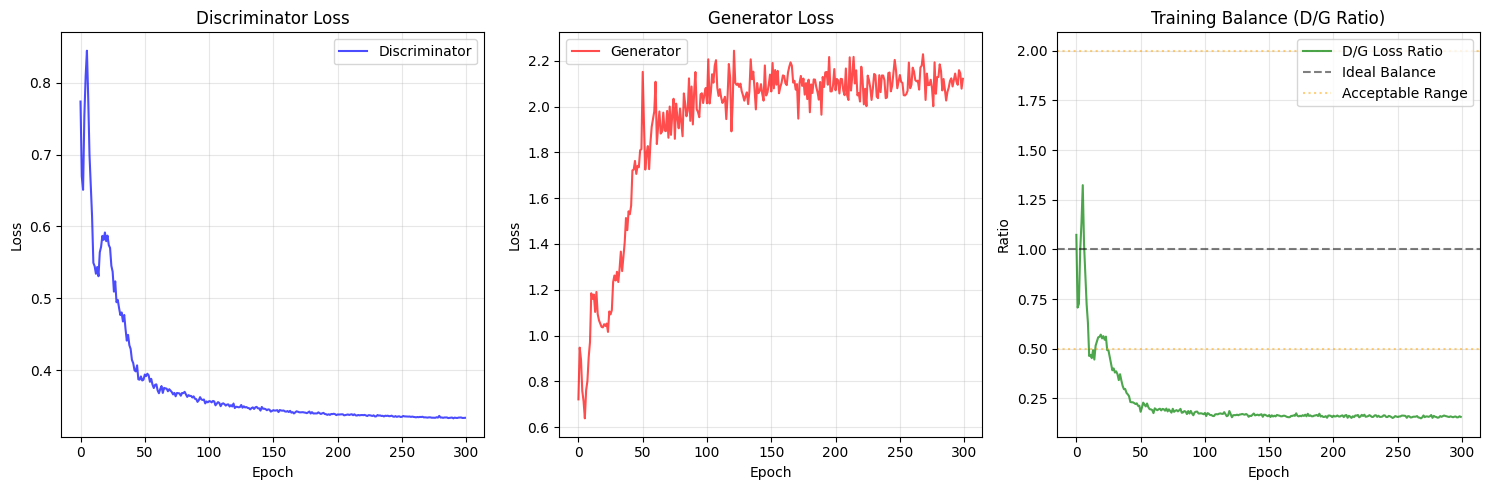

Generated data shape: (552, 4500, 14)
Generated data range: [-0.9999, 1.0000]
Real data range: [-5.7248, 7.6610]

=== Data Quality Analysis ===
Generated data mean: 0.0332, std: 0.4177
Real data mean: 0.0140, std: 0.9923
Mean difference: 0.0192
Std difference: 0.5746


In [3]:
# IMPROVED TRAINING with better stability parameters
generator, discriminator, d_history, g_history, data_range = train_conditional_gan_conv1d(
    X_train, 
    y_train,
    device, 
    epochs=300,         # More epochs for stable convergence
    batch_size=64,      # Larger batch for stability  
    lr_g=0.001,        # Balanced generator learning rate
    lr_d=0.00001         # Balanced discriminator learning rate (2:1 ratio)
)

num_samples = len(X_train)
# Generate samples for class 0 (normal)
generated_data = generate_conditional_samples(
    generator, 
    num_samples=num_samples, 
    target_class=0, 
    seq_len=normal_data.shape[1], 
    latent_dim=100, 
    device=device, 
    data_range=data_range
)

# Plot training curves with improved visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(d_history, label='Discriminator', color='blue', alpha=0.7)
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(g_history, label='Generator', color='red', alpha=0.7)
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Plot loss ratio for stability analysis
if len(d_history) > 0 and len(g_history) > 0:
    loss_ratio = np.array(d_history) / (np.array(g_history) + 1e-8)
    plt.plot(loss_ratio, label='D/G Loss Ratio', color='green', alpha=0.7)
    plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Ideal Balance')
    plt.axhline(y=0.5, color='orange', linestyle=':', alpha=0.5, label='Acceptable Range')
    plt.axhline(y=2.0, color='orange', linestyle=':', alpha=0.5)
    plt.title('Training Balance (D/G Ratio)')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Combine with real data
combine_data_normal = np.concatenate((generated_data, normal_data), axis=0)
combine_labels_normal = np.concatenate((np.zeros(len(generated_data)), normal_label), axis=0)

print(f"Generated data shape: {generated_data.shape}")
print(f"Generated data range: [{generated_data.min():.4f}, {generated_data.max():.4f}]")
print(f"Real data range: [{normal_data.min():.4f}, {normal_data.max():.4f}]")

# Quality check: Compare statistical properties
print("\n=== Data Quality Analysis ===")
print(f"Generated data mean: {generated_data.mean():.4f}, std: {generated_data.std():.4f}")
print(f"Real data mean: {normal_data.mean():.4f}, std: {normal_data.std():.4f}")
print(f"Mean difference: {abs(generated_data.mean() - normal_data.mean()):.4f}")
print(f"Std difference: {abs(generated_data.std() - normal_data.std()):.4f}")


# FID Score

In [5]:
# ===============================
# FID SCORE EVALUATION
# ===============================

# Test the simplified FID calculation
print("Testing simplified FID calculation...")

# Use smaller subsets for testing
test_real = X_train[:100]  # Use 100 samples for testing
test_generated = generated_data[:100]

print(f"Test real data shape: {test_real.shape}")
print(f"Test generated data shape: {test_generated.shape}")

# Calculate FID score
fid_score = calculate_fid_score(
    real_data=test_real,
    fake_data=test_generated,
    device=device,
    sample_rate=1000,
)

if fid_score is not None:
    print(f"\n🎉 SUCCESS! FID Score: {fid_score:.4f}")
    
    # Interpret the score
    if fid_score < 10:
        quality = "Excellent"
    elif fid_score < 25:
        quality = "Good"
    elif fid_score < 50:
        quality = "Fair"
    elif fid_score < 100:
        quality = "Poor"
    else:
        quality = "Very Poor"
    
    print(f"Quality Assessment: {quality}")
else:
    print("❌ FID calculation failed. Please check the error messages above.")

Testing simplified FID calculation...
Test real data shape: (100, 4500, 14)
Test generated data shape: (100, 4500, 14)
Processing real data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Processing fake data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Calculating FID with 100 samples each...
Real images shape: torch.Size([100, 3, 299, 299])
Fake images shape: torch.Size([100, 3, 299, 299])
Real images range: [0.0000, 0.9816]
Fake images range: [0.0000, 0.9943]
After clamping - Real images range: [0.0000, 0.9816]
After clamping - Fake images range: [0.0000, 0.9943]
FID Score: 38.6489

🎉 SUCCESS! FID Score: 38.6489
Quality Assessment: Fair



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 552
Faulty samples: 182
Generated samples: 552
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 441
Fold 1 - Test: 147 (111 normal, 36 faulty)
Fold 1 - Augmented normal data: 993 samples
Processing data through feature extraction...
Processing 993 samples with multi-channel approach...
Processed 0/993 samples
Processed 100/993 samples
Processed 200/993 samples
Processed 300/993 samples
Processed 400/993 samples
Processed 500/993 samples
Processed 600/993 samples
Processed 700/993 samples
Processed 800/993 samples
Processed 900/993 samples
Processing 147 samples with multi-channel approach...
Processed 0/147 samples
Processed 100/147 samples
Training autoencoder...
Epoch 1/200, Loss: 1.083456
Epoch 2/200, Loss: 0.622439
Epoch 3/200, Loss: 0.529803
Epoch 4/200, Loss: 0.526035
Epoch 5/200, Loss: 0.524991
Epoch 6/200, Loss: 0.525665
Epoch 7/200, Loss: 0

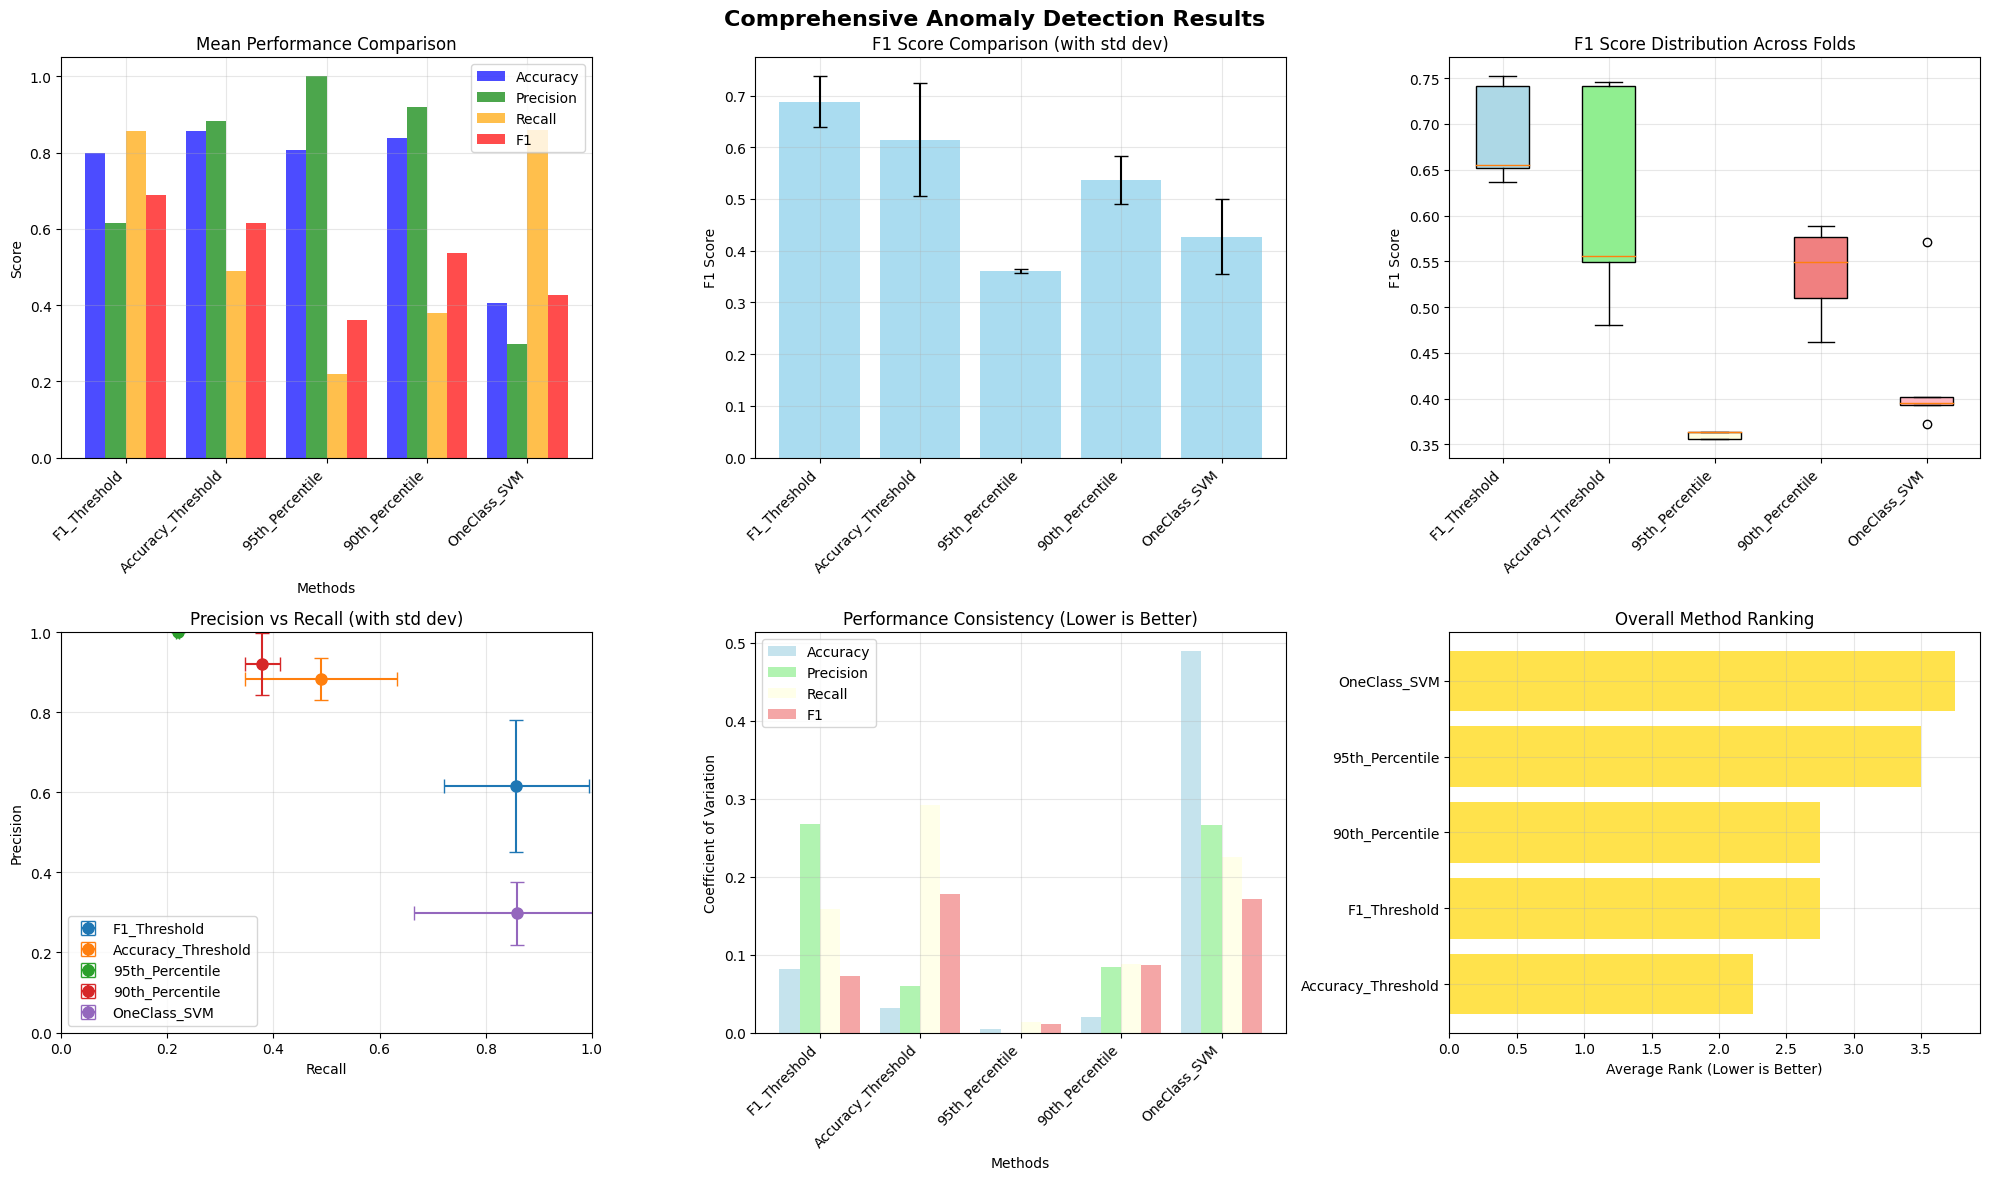


ANOMALY DETECTION RECOMMENDATIONS

🏆 BEST METHODS:
   • Best F1 Score: F1_Threshold (0.6876)
   • Best Accuracy: Accuracy_Threshold (0.8556)

📊 METHOD CHARACTERISTICS:
   • F1_Threshold          : High Recall (catches more anomalies), Variable
   • Accuracy_Threshold    : High Precision (fewer false alarms), Variable
   • 95th_Percentile       : High Precision (fewer false alarms), Stable
   • 90th_Percentile       : High Precision (fewer false alarms), Stable
   • OneClass_SVM          : High Recall (catches more anomalies), Variable

🎯 USE CASE RECOMMENDATIONS:
   • For Critical Systems (minimize false negatives): Use method with highest recall
   • For Cost-Sensitive Systems (minimize false alarms): Use method with highest precision
   • For Balanced Performance: Use F1_Threshold
   • For Simplicity: Use 95th_Percentile - no hyperparameter tuning needed
   • For Robustness: Use OneClass_SVM - adapts to data distribution



({'F1_Threshold': {'accuracy': {'mean': 0.7998043052837573,
    'std': 0.06487956731014913,
    'values': [0.7278911564625851,
     0.7891156462585034,
     0.891156462585034,
     0.7346938775510204,
     0.8561643835616438]},
   'precision': {'mean': 0.6160092228093362,
    'std': 0.16472135322540646,
    'values': [0.47297297297297297,
     0.5471698113207547,
     0.92,
     0.4868421052631579,
     0.6530612244897959]},
   'recall': {'mean': 0.8576576576576576,
    'std': 0.1362273181360143,
    'values': [0.9722222222222222,
     0.8055555555555556,
     0.6216216216216216,
     1.0,
     0.8888888888888888]},
   'f1': {'mean': 0.6875585893201575,
    'std': 0.04941307924015111,
    'values': [0.6363636363636364,
     0.651685393258427,
     0.7419354838709677,
     0.6548672566371682,
     0.7529411764705882]}},
  'Accuracy_Threshold': {'accuracy': {'mean': 0.8556238933929736,
    'std': 0.02683977619502048,
    'values': [0.8435374149659864,
     0.8367346938775511,
     0.8911

In [6]:
run_comprehensive_cross_validation_experiment(X_train, faulty_data, device, generated_data, epochs=200, batch_size=32)